In [1]:
!pip install openpyxl
!pip install seaborn



# Proyecto de Predicción de Precio por Kilo

El objetivo de este proyecto es construir y comparar modelos de machine learning para predecir el precio por kilo de un producto agrícola. La predicción precisa de este precio tiene implicaciones significativas en la toma de decisiones para agricultores y comerciantes, ayudándoles a optimizar estrategias de venta y reducir pérdidas.

El dataset contiene más de 1 millón de registros, y se evaluarán dos modelos: **Random Forest** y **XGBoost**. Ambos son ampliamente utilizados en problemas de machine learning relacionados con datos tabulares. A lo largo del proyecto, se medirán métricas como el **Error Cuadrático Medio (MSE)** y la **Raíz del Error Cuadrático Medio (RMSE)** para evaluar el rendimiento de los modelos.

---

## Conceptos Importantes

### MSE (Mean Squared Error)
Es la media de los errores cuadráticos. Se calcula como la diferencia entre los valores reales y predichos al cuadrado, dividida entre el número de observaciones. Es útil para medir la calidad de un modelo, penalizando más los errores grandes.

**Fórmula**:  
\[
MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
\]

---

### RMSE (Root Mean Squared Error)
Es la raíz cuadrada del MSE. Proporciona una métrica en las mismas unidades que la variable objetivo, lo que facilita la interpretación.

**Fórmula**:  
\[
RMSE = \sqrt{MSE}
\]

---

Ambas métricas son útiles para medir qué tan cerca están las predicciones del modelo de los valores reales.



In [1]:
import pandas as pd
import boto3

# Configurar el cliente S3 y la ruta actualizada del archivo
s3_client = boto3.client('s3')
bucket = 'sagemaker-fossa'
file_key = 'fossa/xlsx/Bd_Transacciones.xlsx'

# Descargar el archivo desde S3 a SageMaker Studio
s3_client.download_file(bucket, file_key, 'Bd_Transacciones.xlsx')

In [2]:
# Cargar el archivo CSV desde S3
df = pd.read_csv('Bd_Transacciones.csv')
#df.head()


/tmp/ipykernel_8415/3284868090.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Bd_Transacciones.csv')


# Objetivo del Proyecto

**Objetivo**: Determinar la viabilidad del dataset y seleccionar variables relevantes para predecir la variable objetivo **Precio_Kilo**, que representa el precio por kilo de venta de ganado.

---

## Acciones Realizadas

- **Eliminación de columnas irrelevantes**:  
  Se han removido las siguientes columnas del dataset por no aportar valor a la predicción:  
  - `Clave_instancia`
  - `Marca`
  - `Raza`
  - `Tipo_Documento_Venta`
  - `Documento_Venta`
  - `Rut_Comprador`
  - `Tipo_Documento_Compra`
  - `Documento_Compra`
  - `Rut_Vendedor`
  - `Corredor_Compra`

- **Limpieza de datos**:  
  Se realizó una limpieza de los campos restantes para asegurar la calidad de los datos antes de entrenar los modelos.

---


Explicación:
Qué hace:

Elimina columnas consideradas irrelevantes para el análisis.

Las columnas eliminadas incluyen identificadores únicos, datos de compradores/vendedores, y otros campos que no afectan directamente el cálculo del precio por kilo.

Por qué es necesario:

Simplifica el conjunto de datos al enfocarse solo en las variables relevantes, lo que reduce la dimensionalidad y mejora la eficiencia de los modelos.

Conceptos Relacionados:

Inplace: Al establecer inplace=True, las modificaciones se aplican directamente al DataFrame original sin necesidad de reasignarlo.

In [3]:
# Eliminar las columnas irrelevantes
drop_columns = [
    'Clave_instancia', 'Marca', 'Raza', 'Tipo_Documento_Venta',
    'Documento_Venta', 'Rut_Comprador', 'Tipo_Documento_Compra', 
    'Documento_Compra', 'Rut_Vendedor', 'Corredor_Compra'
]
df.drop(columns=drop_columns, inplace=True)



**Qué hace:**

- Convierte la columna Fecha en formato de fecha y hora.
- Extrae información útil como el año, mes y día en nuevas columnas.
- Elimina la columna original Fecha una vez procesada.

**Por qué es necesario:**

Los modelos de machine learning no trabajan directamente con datos en formato de fecha, por lo que es común extraer características numéricas relevantes.
Por ejemplo, el precio por kilo podría variar según el año o la temporada (mes).

**Datetime:** Tipo de dato para trabajar con fechas y horas, permitiendo operaciones como extracción de componentes y cálculo de diferencias temporales.


In [4]:
# Asegurarse de que la columna 'Fecha' esté en formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Extraer características numéricas de la fecha (por ejemplo, año, mes y día)
df['Año'] = df['Fecha'].dt.year
df['Mes'] = df['Fecha'].dt.month
df['Día'] = df['Fecha'].dt.day

# Eliminar la columna original de 'Fecha'
df = df.drop(columns=['Fecha'])

**Qué hace:**

- Calcula el número de valores nulos, el total de filas, y el porcentaje de valores nulos por columna.
* Crea un DataFrame que resume esta información para su revisión.


**Identificar columnas con valores nulos permite tomar decisiones sobre cómo manejarlos:**
- Eliminar columnas con demasiados nulos.
- Rellenar valores nulos con la media, mediana, o un valor constante.

**Valores nulos:** Representan datos faltantes o no registrados, y pueden afectar negativamente el entrenamiento de modelos si no se gestionan adecuadamente.

In [27]:
# Calcular los valores nulos por columna
nulos = df.isnull().sum()

# Calcular el total de valores por columna
total = len(df)

# Calcular el porcentaje de nulos sobre el total de valores
porcentaje_nulos = (nulos / total) * 100

# Crear un nuevo DataFrame con los resultados
tabla_nulos = pd.DataFrame({
    'Campos Nulos': nulos,
    'Total de Campos': total,
    'Porcentaje de Nulos (%)': porcentaje_nulos
})

# Mostrar la tabla resultante
print(tabla_nulos)

                    Campos Nulos  Total de Campos  Porcentaje de Nulos (%)
idRegistro                     0           981467                      0.0
Tipo_Remate                    0           981467                      0.0
Recinto                        0           981467                      0.0
Cantidad                       0           981467                      0.0
Especie                        0           981467                      0.0
Precio_Kilo                    0           981467                      0.0
Kilos                          0           981467                      0.0
Neto                           0           981467                      0.0
Corral                         0           981467                      0.0
Correlativo                    0           981467                      0.0
Corredor_Venta                 0           981467                      0.0
Grupo                          0           981467                      0.0
Categoria                

In [6]:
# Descripción estadística del dataset
#df.head()
df.dtypes

idRegistro          int64
Tipo_Remate        object
Recinto             int64
Cantidad            int64
Especie             int64
Precio_Kilo       float64
Kilos               int64
Neto                int64
Corral              int64
Correlativo         int64
Corredor_Venta      int64
Grupo              object
Categoria          object
Peso              float64
Año                 int32
Mes                 int32
Día                 int32
dtype: object

**Qué hace:**

- Analiza las distribuciones de las variables categóricas clave: Tipo_Remate, Grupo y Categoria.
- Devuelve un resumen de cuántos registros pertenecen a cada categoría.

**Por qué es necesario:**

- Conocer la distribución ayuda a identificar categorías desbalanceadas o poco representadas que podrían requerir reagrupación o eliminación.
- Las categorías con pocos datos pueden agregar ruido a los modelos y dificultar su aprendizaje.

**Value Counts:** Método de pandas que cuenta la frecuencia de cada valor único en una columna.

In [7]:
pd.options.display.max_rows = 100
# Verificar la distribución de las variables categóricas
categorical_distributions = {
    'Tipo_Remate': df['Tipo_Remate'].value_counts(),
    'Grupo': df['Grupo'].value_counts(),
    'Categoria': df['Categoria'].value_counts()
}
categorical_distributions




{'Tipo_Remate': Tipo_Remate
 F    960873
 P     20608
 Name: count, dtype: int64,
 'Grupo': Grupo
 Bovinos        915420
 Ovinos          25777
 Porcinos        24489
 Equinos         13419
 Caprinos         1996
 Maquinarias       361
 0                  14
 Camelidos           6
 Name: count, dtype: int64,
 'Categoria': Categoria
 TERNEROS                    124456
 VACA GORD.                   76924
 TERNEROS CARNE               70614
 VAQ.ENGORDA                  51158
 VACA EXPORTACION             41060
 VACA GOR.CARNE               38472
 NOV.GORDO                    37026
 VAQ.GORD.                    34703
 TERNERAS                     31346
 NOV.GORD.CARNE               30556
 TOROS                        28904
 TERNERAS CARNE               27935
 TERNEROS LECHE               27534
 VAQ. GORD.CARNE              27014
 VACA.ENG.                    26717
 VACA CARNAZA                 26113
 NOV.ENG.                     25978
 VAQ. ENG.CARNE               22290
 BUEYES           

**Qué hace:**

- Filtra el dataset eliminando filas donde las columnas Grupo o Categoria tengan un valor de '0' (posiblemente marcadores de datos inválidos).
- Elimina registros donde el campo Peso tiene valores nulos, ya que es una variable relevante para el análisis.

**Por qué es necesario:**

- Asegura que solo se trabajen con registros válidos y completos, eliminando datos inconsistentes o incompletos.

**Subsetting:** Técnica para filtrar filas basándose en condiciones específicas en pandas.


In [16]:
# Filtrar los registros donde 'Grupo' y 'Categoria' no sean '0'
df = df[(df['Grupo'] != '0') & (df['Categoria'] != '0')]
df = df.dropna(subset=['Peso'])

**Qué hace:**

- Agrupa categorías de la columna Categoria con menos de 5000 registros en una nueva categoría llamada Otras.
- Las categorías frecuentes permanecen sin cambios.

**Por qué es necesario:**

- Reduce la dimensionalidad al evitar que las categorías con poca representación generen demasiadas variables al codificarlas.
- Mejora el rendimiento del modelo y evita que datos poco frecuentes tengan un impacto desproporcionado.

**Umbral de Frecuencia:** Valor usado para determinar qué categorías son lo suficientemente comunes como para conservarse en el análisis.


In [9]:
# Paso 1: Definir el umbral de frecuencia
# Definimos un umbral, por ejemplo, 5,000 registros para agrupar en otros
umbral_frecuencia = 5000

# Paso 2: Identificar categorías frecuentes
# Obtenemos el conteo de cada categoría en 'Categoria'
categoria_counts = df['Categoria'].value_counts()

# Creamos una lista de categorías frecuentes que tienen un conteo mayor al umbral
categorias_frecuentes = categoria_counts[categoria_counts > umbral_frecuencia].index.tolist()

# Paso 3 ajustado: Agrupar categorías menores bajo "Otras" usando .loc[]
df.loc[:, 'Categoria_agrupada'] = df['Categoria'].apply(lambda x: x if x in categorias_frecuentes else 'Otras')

# Verificar el resultado de la agrupación (opcional)
print(df['Categoria_agrupada'].value_counts())

Categoria_agrupada
TERNEROS                124456
VACA GORD.               76924
TERNEROS CARNE           70614
VAQ.ENGORDA              51158
VACA EXPORTACION         41060
VACA GOR.CARNE           38472
NOV.GORDO                37026
VAQ.GORD.                34703
TERNERAS                 31346
NOV.GORD.CARNE           30556
Otras                    29409
TOROS                    28904
TERNERAS CARNE           27935
TERNEROS LECHE           27534
VAQ. GORD.CARNE          27014
VACA.ENG.                26717
VACA CARNAZA             26113
NOV.ENG.                 25978
VAQ. ENG.CARNE           22290
BUEYES                   19016
CERDO MALTON             15749
VACA GOR.LECHE           15741
NOV.ENG.CARNE            15579
CORDEROS                 14294
VAQUILLA EXPORTACION     13436
VACA ENG.CARNE.          11282
VAQ. ENG.LECHE           10958
OVEJAS                   10255
NOV.ENG.LECHE             8706
CABALLO                   8489
TERNERAS LECHE            7674
TORETE              

**Qué hace:**

- Convierte la columna Categoria_agrupada en múltiples columnas binarias mediante One-Hot Encoding.
- Cada nueva columna representa una categoría, con valores 0 (no pertenece) y 1 (pertenece).

**Por qué es necesario:**

- Los modelos de machine learning no trabajan directamente con datos categóricos. One-Hot Encoding es una técnica estándar para convertir categorías en variables numéricas.

**One-Hot Encoding:** Técnica para transformar variables categóricas en columnas binarias para su uso en modelos de machine learning.

In [13]:
# Paso 4: Aplicar One-Hot Encoding en la columna agrupada
# Aplicamos One-Hot Encoding solo en la columna agrupada
df = pd.get_dummies(df, columns=['Categoria_agrupada'], prefix='Categoria')

# Convertir las columnas que comienzan con 'Categoria_' a valores 0 y 1
categoria_columns = [col for col in df.columns if col.startswith('Categoria_')]
df[categoria_columns] = df[categoria_columns].astype(int)

# Eliminamos la columna original 'Categoria' si aún está presente
df.drop(columns=['Categoria'], inplace=True, errors='ignore')

# Vista del DataFrame resultante (opcional)
print(df.head())


   idRegistro Tipo_Remate  Recinto  Cantidad  Especie  Precio_Kilo  Kilos  \
0      594075           F        3        12        3       1175.0   3630   
1      594076           F        3         4        3       1295.0    930   
2      594077           F        3         4        3       1055.0    890   
3      594078           F        3         8        3       1200.0   1850   
4      594079           F        3         2       10        965.0   1290   

      Neto  Corral  Correlativo  ...  Categoria_VACA PAR./CRIA  \
0  4265250      13            5  ...                         0   
1  1204350       1            1  ...                         0   
2   938950       1            2  ...                         0   
3  2220000       1            3  ...                         0   
4  1244850      33            5  ...                         0   

  Categoria_VACA.ENG.  Categoria_VACA/CRIA  Categoria_VAQ. ENG.CARNE  \
0                   0                    0                         0

**Qué hace:**

- Selecciona solo las columnas numéricas del DataFrame para calcular la matriz de correlación.
- Filtra y ordena las correlaciones de todas las variables respecto a la variable objetivo Precio_Kilo.

**Por qué es necesario:**

- Identificar las variables que tienen mayor correlación con el precio por kilo ayuda a comprender cuáles son más relevantes para el modelo.
- Permite descartar variables con correlación cercana a cero que aportan poco al análisis.

**Correlación:** Mide la relación entre dos variables. Los valores cercanos a 1 o -1 indican relaciones fuertes, mientras que los cercanos a 0 indican poca o ninguna relación.


In [11]:
# Filtrar solo las columnas numéricas para calcular la matriz de correlación
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación para las variables numéricas
correlation_matrix = numeric_df.corr()

# Filtrar la correlación de las variables con respecto a 'Precio_Kilo'
price_correlation = correlation_matrix['Precio_Kilo'].sort_values(ascending=False)

# Mostrar la correlación de cada variable con 'Precio_Kilo'
print(price_correlation)


Precio_Kilo       1.000000
idRegistro        0.074142
Especie           0.033866
Neto              0.026139
Corredor_Venta    0.011041
Cantidad          0.008251
Correlativo       0.001715
Kilos            -0.004009
Recinto          -0.004968
Corral           -0.010467
Peso             -0.027115
Name: Precio_Kilo, dtype: float64


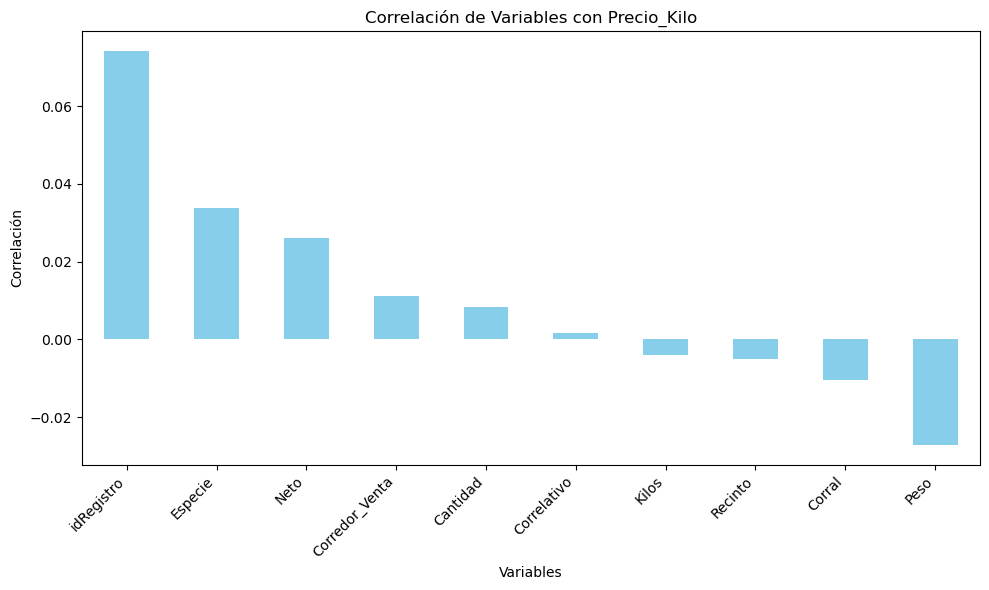

In [12]:
import matplotlib.pyplot as plt

# Graficar la correlación de cada variable con respecto a 'Precio_Kilo'
plt.figure(figsize=(10, 6))
price_correlation.drop('Precio_Kilo').plot(kind='bar', color='skyblue')  # Excluimos 'Precio_Kilo' para una visualización más clara
plt.title("Correlación de Variables con Precio_Kilo")
plt.xlabel("Variables")
plt.ylabel("Correlación")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Variables con Correlación Positiva Notable:**

**idRegistro:** Aunque tiene la mayor correlación positiva, esta variable parece ser un identificador. Generalmente, los identificadores no aportan significado en la predicción y deberían ser eliminados.
**Especie:** Esta variable tiene una correlación significativa positiva con el precio por kilo. Esto indica que diferentes especies pueden influir en el precio, probablemente debido a su calidad, valor de mercado, o demanda.
**Neto:** La cantidad total neta (en valor monetario) también tiene una correlación positiva con el precio por kilo. Esto sugiere que transacciones de mayor valor están asociadas a precios por kilo más altos.

**Variables con Correlación Moderada:**

**Corredor_Venta y Cantidad:** Estas variables tienen una correlación positiva baja con Precio_Kilo. Es posible que representen aspectos operativos que tienen un impacto menor en la determinación del precio.

**Variables con Correlación Negativa:**

**Peso:** La correlación negativa sugiere que un mayor peso puede estar asociado a un precio por kilo más bajo. Esto podría deberse a que animales más pesados tienden a ser menos costosos por kilo debido a su calidad o estructura de mercado.

**Variables con Correlación Insignificante:**

Recinto, Corral, y otras variables cercanas a cero muestran poca o ninguna relación con el precio. Estas variables probablemente no aportan valor predictivo y podrían ser eliminadas del modelo.

In [18]:
# Crear una lista de columnas a eliminar basadas en correlación cercana a cero o sin valor agregado
columns_to_drop = ['idRegistro', 'Corredor_Venta', 'Corredor_Compra', 'Categoria_Otras']

# Seleccionar solo las columnas de interés que tienen alguna correlación con Precio_Kilo
df_reduced = df.drop(columns=columns_to_drop, errors='ignore')

# Verificar la estructura del nuevo conjunto de datos
df_reduced.head()


,Tipo_Remate,Recinto,Cantidad,Especie,Precio_Kilo,Kilos,Neto,Corral,Correlativo,Grupo,Categoria,Peso,Año,Mes,Día,Categoria_agrupada
0,F,3,12,3,1175.0,3630,4265250,13,5,Bovinos,TERNEROS,302.50,2012,11,7,TERNEROS
1,F,3,4,3,1295.0,930,1204350,1,1,Bovinos,TERNEROS,232.50,2012,11,7,TERNEROS
2,F,3,4,3,1055.0,890,938950,1,2,Bovinos,TERNEROS,222.50,2012,11,7,TERNEROS
3,F,3,8,3,1200.0,1850,2220000,1,3,Bovinos,TERNEROS,231.25,2012,11,7,TERNEROS
4,F,3,2,10,965.0,1290,1244850,33,5,Bovinos,BUEYES,645.00,2012,11,7,BUEYES


**Qué hace:**

- Selecciona solo las variables cuya correlación absoluta con Precio_Kilo es mayor a un umbral arbitrario (0.003 en este caso).
- Crea un nuevo DataFrame reducido que contiene solo estas variables.
- Mejora la eficiencia de los modelos al reducir la cantidad de variables, eliminando aquellas que aportan poca o ninguna información útil.

In [14]:
# Seleccionar columnas con correlación distinta de cero (umbral arbitrario para eliminar las más cercanas a cero)
# Aquí consideramos variables con correlación en valor absoluto mayor a 0.003 (se puede ajustar según criterio)
significant_columns = price_correlation[price_correlation.abs() > 0.003].index.tolist()

# Crear un nuevo DataFrame con solo las columnas seleccionadas
df_significant = df[significant_columns]

# Vista preliminar del DataFrame reducido
df_significant.head()


,Precio_Kilo,idRegistro,Especie,Neto,Corredor_Venta,Cantidad,Kilos,Recinto,Corral,Peso
0,1175.0,594075,3,4265250,0,12,3630,3,13,302.50
1,1295.0,594076,3,1204350,0,4,930,3,1,232.50
2,1055.0,594077,3,938950,0,4,890,3,1,222.50
3,1200.0,594078,3,2220000,0,8,1850,3,1,231.25
4,965.0,594079,10,1244850,0,2,1290,3,33,645.00


In [15]:
# Filtrar solo las columnas numéricas para calcular la matriz de correlación
numeric_df = df_significant.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación para las variables numéricas
correlation_matrix = numeric_df.corr()

# Filtrar la correlación de las variables con respecto a 'Precio_Kilo'
price_correlation = correlation_matrix['Precio_Kilo'].sort_values(ascending=False)

# Mostrar la correlación de cada variable con 'Precio_Kilo'
print(price_correlation)

Precio_Kilo       1.000000
idRegistro        0.074142
Especie           0.033866
Neto              0.026139
Corredor_Venta    0.011041
Cantidad          0.008251
Kilos            -0.004009
Recinto          -0.004968
Corral           -0.010467
Peso             -0.027115
Name: Precio_Kilo, dtype: float64


**División del Dataset:**

Utiliza train_test_split de scikit-learn para dividir el conjunto de datos en:

**Entrenamiento (80%):** Usado para ajustar los parámetros del modelo.
**Validación (20%):** Usado para evaluar el desempeño del modelo.
Se define un random_state (42) para garantizar que la división sea reproducible.

**Exportar a CSV:**
Los conjuntos de datos resultantes se guardan como archivos CSV (train.csv y validation.csv) sin índices ni encabezados, ya que SageMaker prefiere este formato para cargar datos.

**Cargar en S3:**
- Los archivos CSV se suben a un bucket de S3, donde estarán disponibles para el entrenamiento y validación del modelo.
- Se generan rutas URI de S3 (train_s3_uri y validation_s3_uri) que se usarán más adelante para configurar el modelo en SageMaker.


- Dividir el dataset asegura que el modelo no vea los datos de validación durante el entrenamiento, permitiendo una evaluación imparcial de su rendimiento.
- Subir los datos a S3 es un paso obligatorio para usar SageMaker, ya que este servicio utiliza S3 como fuente principal para datos.

**Distribución del Dataset:**

- Al dividir los datos en entrenamiento (80%) y validación (20%), se busca un equilibrio que permita al modelo aprender de la mayoría de los datos mientras se evalúa su generalización.
- Podría ser útil realizar una inspección posterior para asegurarse de que las distribuciones de las variables sean similares en ambos conjuntos.

**Formato Compatible:**

- Convertir a CSV sin encabezados ni índices facilita la compatibilidad con SageMaker y asegura que no haya errores en la lectura.

**Train-Test Split:** Técnica común para dividir datos en partes para entrenamiento y evaluación. Se usa random_state para garantizar que los resultados sean reproducibles.
**S3 (Simple Storage Service):** Servicio de almacenamiento de AWS que facilita la gestión de datos en aplicaciones distribuidas.
- El uso del parámetro random_state en la división asegura que los mismos datos de entrenamiento y validación se obtengan en futuras ejecuciones.

In [19]:
from sklearn.model_selection import train_test_split
import pandas as pd
import boto3

# Dividir el dataset en entrenamiento (80%) y validación (20%)
train_df, val_df = train_test_split(df_significant, test_size=0.2, random_state=42)

# Guardar los conjuntos de datos en archivos CSV
train_df.to_csv("train.csv", index=False, header=False)
val_df.to_csv("validation.csv", index=False, header=False)

# Subir los archivos a S3
s3_client = boto3.client('s3')
bucket = 'sagemaker-fossa'  # Reemplaza con tu bucket de S3
s3_client.upload_file("train.csv", bucket, "fossa/train.csv")
s3_client.upload_file("validation.csv", bucket, "fossa/validation.csv")

# Rutas de los archivos en S3
train_s3_uri = f"s3://{bucket}/fossa/train.csv"
validation_s3_uri = f"s3://{bucket}/fossa/validation.csv"

print("Datos de entrenamiento y validación subidos a S3.")
print("Entrenamiento:", train_s3_uri)
print("Validación:", validation_s3_uri)



Datos de entrenamiento y validación subidos a S3.
Entrenamiento: s3://sagemaker-fossa/fossa/train.csv
Validación: s3://sagemaker-fossa/fossa/validation.csv


**Configuración del entorno de SageMaker:**

Se inicializa una sesión de SageMaker y se obtiene el rol necesario para ejecutar las tareas de entrenamiento. Esto asegura que SageMaker tenga los permisos adecuados para acceder a los recursos, como S3.

**Imagen de XGBoost:**

- Se utiliza la función sagemaker.image_uris.retrieve para obtener la URI de la imagen Docker de XGBoost proporcionada por AWS. Esta imagen contiene el entorno preconfigurado para ejecutar modelos de XGBoost.
- La versión especificada es 1.5-1, lo cual asegura la compatibilidad con el entorno de SageMaker.

**Configuración del estimador:**

- El estimador define las características de entrenamiento, como el tipo de instancia (ml.m5.large), la cantidad de instancias (1) y la ruta en S3 donde se almacenará el modelo entrenado.
- Esta configuración permite escalar el entrenamiento si fuera necesario (por ejemplo, usando varias instancias).

**Hiperparámetros de XGBoost:**

- objective="reg:squarederror": Configura XGBoost para resolver un problema de regresión minimizando el error cuadrático medio.
- num_round=100: Establece el número de iteraciones para el modelo.
- max_depth=5: Limita la profundidad de los árboles, controlando la complejidad y ayudando a evitar el sobreajuste.
- eta=0.2: Define la tasa de aprendizaje, lo que afecta qué tan rápido el modelo converge.
- subsample=0.8 y colsample_bytree=0.8: Hiperparámetros que controlan el muestreo de datos y características, respectivamente, para reducir el sobreajuste.

**Entradas de datos para SageMaker:**

- Los datos de entrenamiento y validación se especifican usando la clase TrainingInput, con las URI previamente generadas y el tipo de contenido (text/csv).
- Esto permite a SageMaker acceder directamente a los datos almacenados en S3.

**Entrenamiento del modelo:**

La función fit inicia el proceso de entrenamiento en SageMaker, utilizando los datos de entrenamiento y validación configurados previamente.

**Insights**

- Escalabilidad: La configuración permite entrenar el modelo en una instancia única, pero podría extenderse fácilmente a varias instancias para manejar datasets más grandes.
- Control del modelo: Los hiperparámetros están bien configurados para un modelo inicial, pero se podrían ajustar más para mejorar el rendimiento.
- Compatibilidad con S3: SageMaker utiliza S3 como fuente y destino para datos y modelos, lo que facilita la integración con otros servicios de AWS.
- Flexibilidad: XGBoost es una opción robusta para problemas de regresión, y su integración con SageMaker automatiza varios pasos complejos.

In [25]:
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.amazon.amazon_estimator import get_image_uri

# Configurar el entorno de SageMaker
session = sagemaker.Session()
role = sagemaker.get_execution_role()

# Definir la URI de la imagen de XGBoost proporcionada por Amazon
container = sagemaker.image_uris.retrieve("xgboost", session.boto_region_name, "1.5-1")

# Configurar el estimador de XGBoost
xgboost_estimator = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",  # Tipo de instancia; puedes cambiarlo según tus necesidades
    output_path=f"s3://{bucket}/fossa/output",  # Ruta para guardar el modelo entrenado
    sagemaker_session=session
)

# Configurar los hiperparámetros de XGBoost
xgboost_estimator.set_hyperparameters(
    objective="reg:squarederror",  # Para problemas de regresión
    num_round=100,  # Número de iteraciones
    max_depth=5,
    eta=0.2,
    subsample=0.8,
    colsample_bytree=0.8
)

# Especificar la entrada de datos para entrenamiento y validación
train_input = TrainingInput(s3_data=train_s3_uri, content_type="text/csv")
validation_input = TrainingInput(s3_data=validation_s3_uri, content_type="text/csv")

# Iniciar el entrenamiento
xgboost_estimator.fit({"train": train_input, "validation": validation_input})


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-10-28-17-15-18-800


2024-10-28 17:15:23 Starting - Starting the training job...
2024-10-28 17:15:38 Starting - Preparing the instances for training...
2024-10-28 17:16:07 Downloading - Downloading input data...
2024-10-28 17:16:52 Downloading - Downloading the training image......
2024-10-28 17:17:43 Training - Training image download completed. Training in progress../miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2024-10-28 17:17:48.872 ip-10-2-119-65.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-10-28 17:17:48.896 ip-10-2-119-65.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-10-28:17:17:49:INFO] Imported framework sagemaker_xgboost_container.training
[2024-10-28:17:17:49:INFO] Failed to parse hyperparameter objective value reg:sq

**Ajuste de hiperparámetros:**

Se modifican los hiperparámetros del modelo para controlar el sobreajuste y mejorar la generalización:

- num_round=50: Reduce las iteraciones del modelo para evitar ajustes excesivos a los datos de entrenamiento.
- max_depth=3: Limita aún más la profundidad de los árboles, simplificando el modelo y reduciendo la probabilidad de sobreajuste.
- eta=0.1: Una tasa de aprendizaje más baja permite que el modelo ajuste sus pesos de forma más gradual, evitando saltos bruscos.
- subsample=0.7: Disminuye el porcentaje de datos utilizados para entrenar cada árbol, introduciendo aleatoriedad para mejorar la generalización.
- colsample_bytree=0.7: Similar a subsample, pero aplicado a las características, lo que ayuda a reducir la dependencia de ciertas variables.

**Reentrenamiento del modelo:**
Se ejecuta nuevamente el proceso de entrenamiento con los nuevos hiperparámetros, utilizando los mismos datos de entrada (entrenamiento y validación) definidos previamente.

**Control del sobreajuste:** Los ajustes realizados buscan un equilibrio entre la complejidad del modelo y su capacidad de generalizar a nuevos datos.
**Iteración gradual:** El uso de eta más bajo permite al modelo realizar cambios incrementales, lo que puede llevar a una mejor convergencia.
**Submuestreo:** Tanto el muestreo de datos como el de características son estrategias efectivas para manejar datasets grandes y reducir la varianza del modelo.


In [26]:
# Ajustar los hiperparámetros para reducir el sobreajuste en XGBoost
xgboost_estimator.set_hyperparameters(
    objective="reg:squarederror",
    num_round=50,  # Reducir el número de rondas
    max_depth=3,  # Reducir la profundidad máxima del árbol
    eta=0.1,  # Disminuir la tasa de aprendizaje
    subsample=0.7,  # Reducir el submuestreo de datos
    colsample_bytree=0.7  # Reducir el submuestreo de características
)

# Reentrenar XGBoost
xgboost_estimator.fit({"train": train_input, "validation": validation_input})


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-10-28-17-34-42-324


2024-10-28 17:34:42 Starting - Starting the training job...
2024-10-28 17:35:05 Starting - Preparing the instances for training...
2024-10-28 17:35:35 Downloading - Downloading input data......
2024-10-28 17:36:26 Downloading - Downloading the training image...
2024-10-28 17:37:17 Training - Training image download completed. Training in progress.../miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2024-10-28 17:37:22.548 ip-10-0-197-220.ec2.internal:8 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-10-28 17:37:22.574 ip-10-0-197-220.ec2.internal:8 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-10-28:17:37:22:INFO] Imported framework sagemaker_xgboost_container.training
[2024-10-28:17:37:22:INFO] Failed to parse hyperparameter objective value reg

Overwriting train_rf.py


**Configuración del modelo Random Forest en SageMaker:**

**entry_point="train_rf.py":** Especifica el archivo que contiene la lógica de entrenamiento del modelo. Este archivo será ejecutado dentro del entorno administrado de SageMaker.

**Instancia y recursos:**
instance_count=1 y instance_type="ml.m5.large": Define que se usará una única instancia de tipo ml.m5.large para el entrenamiento. Este tipo de instancia ofrece un buen balance entre costo y capacidad de cómputo.
**framework_version="0.23-1":** Utiliza la versión 0.23-1 de Scikit-Learn, compatible con SageMaker.
**Rol (role):** El rol de IAM proporciona los permisos necesarios para acceder a recursos como S3 y ejecutar tareas en SageMaker.
Configuración de hiperparámetros:

**n_estimators=100:** Número de árboles en el bosque, lo que incrementa la estabilidad y precisión del modelo.
**max_depth=10:** Limita la profundidad de los árboles, ayudando a controlar el sobreajuste.
**min_samples_split=2:** Requiere al menos dos muestras para dividir un nodo.
**min_samples_leaf=1**: Cada hoja debe tener al menos una muestra, permitiendo capturar información granular.

**Entrenamiento del modelo:**
fit: Inicia el proceso de entrenamiento, utilizando los datos de entrenamiento y validación alojados en S3. SageMaker administra la infraestructura necesaria, simplificando el proceso para el usuario.

**Modularidad del entrenamiento:**
**train_rf.py:**Este archivo encapsula toda la lógica de entrenamiento, incluyendo la carga de datos, preprocesamiento, configuración del modelo y almacenamiento del modelo entrenado. Modularizar el proceso facilita pruebas locales y ajustes futuros.

**Escalabilidad:**
El entrenamiento se realiza en un entorno gestionado por SageMaker, lo que permite escalar los recursos si fuera necesario (por ejemplo, entrenar con más datos o utilizar instancias más potentes).

**Control del modelo:**
Los hiperparámetros iniciales están configurados para encontrar un balance entre rendimiento y complejidad, pero pueden ajustarse con técnicas como búsqueda en malla (grid search) o aleatoria (random search).

**Búsqueda en malla (Grid Search):**
¿Qué es? Se exploran todas las combinaciones posibles de un conjunto predefinido de valores para los hiperparámetros.
**Ventajas:** Garantiza que se prueben todas las configuraciones posibles dentro del espacio definido.
**Desventajas:** Es computacionalmente costosa, especialmente si hay muchos hiperparámetros o valores a evaluar.

**Búsqueda aleatoria (Random Search):**
¿Qué es? En lugar de explorar todas las combinaciones posibles, selecciona un número aleatorio de combinaciones dentro del espacio de búsqueda.
Ventajas: Es más eficiente en términos computacionales, especialmente cuando el espacio de búsqueda es grande.
Desventajas: Puede pasar por alto configuraciones óptimas si no se prueba suficiente cantidad de combinaciones.

**Reproducibilidad:**
Al utilizar un entorno estandarizado en SageMaker, es posible repetir el proceso en diferentes etapas o con nuevos datos, obteniendo resultados consistentes.

In [46]:
# Configurar el estimador de Random Forest
rf_estimator = SKLearn(
    entry_point="train_rf.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version="0.23-1",
    sagemaker_session=session
)

# Configurar hiperparámetros
rf_estimator.set_hyperparameters(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1
)

# Ejecutar el entrenamiento
rf_estimator.fit({"train": train_input, "validation": validation_input})




INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2024-10-29-00-12-11-241


2024-10-29 00:12:13 Starting - Starting the training job...
2024-10-29 00:12:28 Starting - Preparing the instances for training...
2024-10-29 00:12:55 Downloading - Downloading input data...
2024-10-29 00:13:25 Downloading - Downloading the training image...
2024-10-29 00:14:17 Training - Training image download completed. Training in progress.
2024-10-29 00:14:17 Uploading - Uploading generated training model.2024-10-29 00:14:11,402 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-10-29 00:14:11,407 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-29 00:14:11,461 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-10-29 00:14:11,677 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-29 00:14:11,695 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-29 00:14:11,712 sagemaker-training-toolkit INF

UnexpectedStatusException: Error for Training job sagemaker-scikit-learn-2024-10-29-00-12-11-241: Failed. Reason: AlgorithmError: framework error: 
Traceback (most recent call last):
  File "/miniconda3/lib/python3.7/site-packages/sagemaker_containers/_trainer.py", line 84, in train
    entrypoint()
  File "/miniconda3/lib/python3.7/site-packages/sagemaker_sklearn_container/training.py", line 39, in main
    train(environment.Environment())
  File "/miniconda3/lib/python3.7/site-packages/sagemaker_sklearn_container/training.py", line 35, in train
    runner_type=runner.ProcessRunnerType)
  File "/miniconda3/lib/python3.7/site-packages/sagemaker_training/entry_point.py", line 100, in run
    wait, capture_error
  File "/miniconda3/lib/python3.7/site-packages/sagemaker_training/process.py", line 291, in run
    cwd=environment.code_dir,
  File "/miniconda3/lib/python3.7/site-packages/sagemaker_training/process.py", line 208, in check_error
    info=extra_info,
sagemaker_training.errors.ExecuteUserScriptError: ExecuteUserScriptError:
ExitCode 1
ErrorMessage ""
Command "/miniconda3/bin/python train_rf.py --max_depth 10 --min

In [36]:
import os
import pandas as pd

# Cargar los datos de entrenamiento y validación desde los archivos CSV locales
# Cambia las rutas de acuerdo a tu entorno local si es necesario
train_data = pd.read_csv("train.csv", header=None)
val_data = pd.read_csv("validation.csv", header=None)

# Verifica las primeras filas de los datos de entrenamiento y validación
print("Datos de entrenamiento:")
print(train_data.head())
print("\nDatos de validación:")
print(val_data.head())



Datos de entrenamiento:
        0       1   2        3  4  5     6  7    8           9
0   775.0  307749   6   456475  0  1   589  1  150  589.000000
1  1860.0  914715  41  3115500  0  4  1675  3   31  418.750000
2   850.0   43693  15   191250  0  4   225  1   83   56.250000
3   180.0   75936  18    36000  0  1   200  1  113  200.000000
4  1230.0  246358   9  1045500  0  3   850  6   45  283.333333

Datos de validación:
        0       1   2        3   4   5     6  7    8           9
0  1350.0  896695  78  1109700  37   2   822  4   19  411.000000
1  1275.0  403842  41  2180250   0   3  1710  1   28  570.000000
2  1970.0  855977  61  1946360  37   1   988  3   67  988.000000
3     0.0  389219  42        0   0  12  3304  6    8  275.333333
4   575.0  147439  10   530150   0   1   922  1  115  922.000000


In [24]:
# Separar características (X) y variable objetivo (y)
X_train, y_train = train_data.iloc[:, :-1], train_data.iloc[:, -1]
X_val, y_val = val_data.iloc[:, :-1], val_data.iloc[:, -1]

# Verifica las dimensiones de los datos para asegurarse de que la separación fue correcta
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (785174, 9)
y_train shape: (785174,)
X_val shape: (196294, 9)
y_val shape: (196294,)


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Configurar el modelo de Random Forest
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1
)

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de validación
y_pred = model.predict(X_val)

# Calcular el Error Cuadrático Medio (MSE) en el conjunto de validación
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error (MSE) on Validation Set:", mse)


Mean Squared Error (MSE) on Validation Set: 29066.56431348859


In [31]:
import joblib

# Guardar el modelo entrenado en formato .joblib
joblib.dump(model, "model.joblib")
print("Model saved as model.joblib")


Model saved as model.joblib


In [41]:
%%writefile test_script.py

if __name__ == "__main__":
    print("¡Trabajo de prueba ejecutado exitosamente en SageMaker!")


Writing test_script.py


In [42]:
# Cambiar el archivo de entrada en el estimador para probar SageMaker
test_estimator = SKLearn(
    entry_point="test_script.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version="0.23-1",
    sagemaker_session=session
)

# Ejecutar el trabajo de prueba
test_estimator.fit()


INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2024-10-28-23-42-23-631


2024-10-28 23:42:25 Starting - Starting the training job...
2024-10-28 23:42:39 Starting - Preparing the instances for training...
2024-10-28 23:43:13 Downloading - Downloading input data...
2024-10-28 23:43:33 Downloading - Downloading the training image...
2024-10-28 23:44:29 Training - Training image download completed. Training in progress.
2024-10-28 23:44:29 Uploading - Uploading generated training model2024-10-28 23:44:22,626 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-10-28 23:44:22,630 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-28 23:44:22,681 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-10-28 23:44:22,894 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-28 23:44:22,909 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-28 23:44:22,924 sagemaker-training-toolkit INFO